# Flatiron School Phase 3 Project

Student name: **Angelo Turri**

Student pace: **self paced**

Project finish date: **?**

Instructor name: **Mark Barbour**

Blog post URL: **?**

# Stakeholder

A charity organization has a list of Tanzanian water pumps. These pumps can either be entirely functional, functional with some defects in need of repair, or totally non-functional. This organization wants to fix as many of these pumps as it can. However, they have limited funds. To make the most of these funds, they need to be as efficient as possible – this means dispatching only what is necessary to each waterpoint to get the job done. In this hypothetical scenario, non functional water pumps require significantly more resources to repair than functional-needs-repair water pumps.

It is our job to use our available data to make predictions about the waterpoints that this charity organization gave us. The organization wants us to remember that non-functional waterpoints cost more to fix than functional-needs-repair waterpoints. We need to distinguish between them to the best of our ability.

# Data Origin & Description

The data was taken from **https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/**

Descriptions of any of the original variables can be found **below in the dictionary**. These descriptions are also provided here **https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/**.

In [314]:
desc = {'amount_tsh': 'Total static head (amount water available to waterpoint)',
                    'date_recorded': 'The date the row was entered',
                    'funder': 'Who funded the well',
                    'gps_height': 'Altitude of the well',
                    'installer': 'Organization that installed the well', 
                    'id': 'unique identifier of waterpoint',
                    'longitude': 'GPS coordinate',
                    'latitude': 'GPS coordinate',
                    'wpt_name': 'Name of the waterpoint if there is one',
                    'subvillage': 'Geographic location',
                    'region': 'Geographic location',
                    'region_code': 'Geographic location (coded)',
                    'district_code': 'Geographic location (coded)',
                    'lga': 'Geographic location',
                    'ward': 'Geographic location',
                    'population': 'Population around the well',
                    'public_meeting': 'True/False',
                    'recorded_by': 'Group entering this row of data',
                    'scheme_management': 'Who operates the waterpoint',
                    'scheme_name': 'Who operates the waterpoint',
                    'permit': 'If the waterpoint is permitted',
                    'construction_year': 'Year the waterpoint was constructed',
                    'extraction_type': 'The kind of extraction the waterpoint uses',
                    'extraction_type_group': 'The kind of extraction the waterpoint uses',
                    'extraction_type_class': 'The kind of extraction the waterpoint uses',
                    'management': 'How the waterpoint is managed',
                    'management_group': 'How the waterpoint is managed',
                    'payment': 'What the water costs',
                    'payment_type': 'What the water costs',
                    'water_quality': 'The quality of the water',
                    'quality_group': 'The quality of the water',
                    'quantity': 'The quantity of water',
                    'quantity_group': 'The quantity of water',
                    'source': 'The source of the water',
                    'source_type': 'The source of the water',
                    'source_class': 'The source of the water',
                    'waterpoint_type': 'The kind of waterpoint',
                    'waterpoint_type_group': 'The kind of waterpoint'}

# Rationale & Limitations

Why are you using **method**?

What about the current problem makes **method** suitable?

Assumptions of our model


Kind of data used

In [315]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, get_scorer_names, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statistics import mode as md
from matplotlib import pyplot as plt
from IPython.display import clear_output, display_html 
from collections import Counter
from pprint import pprint
from itertools import product
import scipy.stats as ss

In [316]:
# Suppresses needless warnings

import warnings
warnings.filterwarnings("ignore")

In [317]:
# For aesthetics

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [318]:
# Importing data
# testing is for the online competition only; it's not directly relevant to this project

testing = pd.read_csv("tanzanian_water_wells/X_test.csv")
X = pd.read_csv("tanzanian_water_wells/X_train.csv")
y = pd.read_csv("tanzanian_water_wells/y_train.csv")['status_group'].map({'functional': 2, 'functional needs repair': 0, 'non functional': 1})

In [345]:
pd.read_csv("tanzanian_water_wells/X_train.csv").columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [319]:
idx = pd.read_csv("tanzanian_water_wells/X_test.csv")['id']

In [320]:
# Random state for any function in the notebook that uses one.
# This is for reproducibility.

state = 42

# Feature Selection

There are quite a few features in this dataset (37). The descriptions of each of these features was taken from Kaggle and listed below. We will not be using all the features, for several reasons:

- Some do not correlate with the target variable (status_group), e.g., the row ID;
- Others have too many categories;
- Some variables differ massively in their values from one dataset to another;
- Others are near copies of different variables in the same dataset, making it pointless to use them.

### Variable inconsistency across train and test sets

We were given two datasets for analysis – one training dataset, complete with feature and target variables, and a testing dataset, which only had the feature variables (the target values were hidden).

Our goal is to accurately predict the target values in the test dataset. To do this successfully, we must use features in our model that correlate well with the target.

Unfortunately, some of our categorical variables differ in their categories from one dataset to another. Therefore, any model that uses these variables will have less success in the test dataset than in the training dataset - because it will come across numerous unknown categories.

It seems like the following variables should be removed from our features:

- wpt_name
- subvillage
- installer
- funder
- scheme_name
- ward
- date_recorded

In [321]:
differences = []

columns = list(X.select_dtypes(exclude=['float64', 'int64']).columns)

for col in columns:
    
    # This finds all the differences between two sets
    difference = set(list(X[col])) ^ set(list(testing[col]))
    differences.append(len(difference))
    
differences_df = pd.DataFrame({'column': list(columns), 'differences': differences})
differences_df = differences_df.sort_values(by=['differences'], ascending=False)
differences_df.head(10)

,column,differences
3,wpt_name,43128
5,subvillage,15120
2,installer,1584
1,funder,1403
12,scheme_name,1251
8,ward,145
0,date_recorded,51
14,extraction_type,1
23,quantity,0
21,water_quality,0


In [322]:
# Dropping all problem features from both test and train datasets

X = X.drop(list(differences_df['column'])[:7], axis=1)
testing = testing.drop(list(differences_df['column'])[:7], axis=1)

### Dropping variables that do not correlate with the target column

Two variables, namely "id" and "recorded_by", do not correlate with the target column (status_group).

- **id** is a unique numerical identifier for waterpoints; each waterpoint has a different identifier. An identifier such as this one cannot meaningfully correlate with the target column.

- **recorded_by** has only one value in the entire dataset, and therefore cannot correlate with the target column.

In [323]:
X.id

0        69572
1         8776
2        34310
3        67743
4        19728
         ...  
59395    60739
59396    27263
59397    37057
59398    31282
59399    26348
Name: id, Length: 59400, dtype: int64

In [324]:
X.recorded_by.value_counts()

recorded_by
GeoData Consultants Ltd    59400
Name: count, dtype: int64

In [325]:
X = X.drop(['id', 'recorded_by'], axis=1)
testing = testing.drop(['id', 'recorded_by'], axis=1)

# Preprocessing

- Null values are handled
- Certain features are cast as more suitable dtypes
- Categorical variables are encoded as numbers, because strings are longer and clumsier
- Numerical variables are standardized using MinMaxScaler

In [326]:
# Preprocessing for our training dataset


# Eliminating null values
X.scheme_management.fillna("None", inplace=True)
X.permit.fillna('Unknown', inplace=True)
X.public_meeting.fillna('Unknown', inplace=True)

# Casting certain features as different dtypes
X['permit'] = X['permit'].map({True: 'Yes', False: 'No', 'Unknown': 'Unknown'})
X['gps_height'] = X['gps_height'].astype('float64')
X['population'] = X['population'].astype('float64')
X['construction_year'] = X['construction_year'].astype('int64')
X['region_code'] = X['region_code'].astype('str')
X['district_code'] = X['district_code'].astype('str')

# !!IMPORTANT!!
# Separating features into numeric and categorical dataframes for preprocessing.
X_cat = X.select_dtypes(exclude=['float64', 'int64'])
X_cat = X_cat.astype('str')
oe = OrdinalEncoder()
oe.fit(X_cat)
X_cat = pd.DataFrame(oe.transform(X_cat), 
                     index = X_cat.index, 
                     columns = X_cat.columns)

## !!IMPORTANT!!
# Standardizing numercal features using MinMaxScaler
X_numeric = X.select_dtypes(['float64', 'int64'])
mms = MinMaxScaler()
mms.fit(X_numeric)
X_numeric = pd.DataFrame(mms.transform(X_numeric), 
                         columns = X_numeric.columns, 
                         index = X_numeric.index)

In [327]:
# Preprocessing for our test dataset

# Eliminating null values
testing.scheme_management.fillna("None", inplace=True)
testing.permit.fillna('Unknown', inplace=True)
testing.public_meeting.fillna('Unknown', inplace=True)

# Casting certain features as different dtypes
testing['permit'] = testing['permit'].map({True: 'Yes', False: 'No', 'Unknown': 'Unknown'})
testing['gps_height'] = testing['gps_height'].astype('float64')
testing['population'] = testing['population'].astype('float64')
testing['construction_year'] = testing['construction_year'].astype('int64')
testing['region_code'] = testing['region_code'].astype('str')
testing['district_code'] = testing['district_code'].astype('str')

# !!IMPORTANT!!
# Separating features into numeric and categorical dataframes for preprocessing.
testing_cat = testing.select_dtypes(exclude=['float64', 'int64'])
testing_cat = testing_cat.astype('str')
oe = OrdinalEncoder()
oe.fit(testing_cat)
testing_cat = pd.DataFrame(oe.transform(testing_cat), 
                           index = testing_cat.index, 
                           columns = testing_cat.columns)

## !!IMPORTANT!!
# Standardizing numercal features using MinMaxScaler
testing_numeric = testing.select_dtypes(['float64', 'int64'])
mms = MinMaxScaler()
mms.fit(testing_numeric)
testing_numeric = pd.DataFrame(mms.transform(testing_numeric), 
                               columns = testing_numeric.columns, 
                               index = testing_numeric.index)

# Checking for collinearity among the variables

We want to eliminate collinearity. These variables might be strongly correlated with each other, based on the names they were given:

- **region** and **region_code**
- **scheme_management** and **scheme_name**
- **extraction_type**, **extraction_type_group** and **extraction_type_class**
- **management** and **management_group**
- **payment** and **payment_type**
- **water_quality** and **quality_group**
- **quantity** and **quantity_group**
- **source**, **source_type** and **source_class**
- **waterpoint_type** and **waterpoint_type_group**

I will search amongst the correlations between all of our features for evidence of collinearity.

In [328]:
# A helper function that makes any strong correlations easy to spot

def cts(val):
    if (val < -0.5):
        color = 'red'
    elif (val > 0.5):
        color = 'red'
    else: 
        color = 'black'
    return 'color: %s' % color

In [329]:
# Enables us to see all the correlations in this dataframe, as there are quite a few

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.concat([X_numeric, X_cat, y], axis=1).corr().style.applymap(cts)

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,basin,region,region_code,district_code,lga,public_meeting,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
amount_tsh,1.000000,0.076650,0.022134,-0.052670,0.002944,0.016288,0.067915,0.013977,-0.019866,-0.036760,-0.028303,0.010315,-0.000341,0.009852,0.024756,-0.025091,-0.017738,-0.013213,-0.008835,-0.001836,0.013623,-0.118563,0.012624,-0.023995,-0.014526,-0.014526,0.001201,-0.000711,0.034922,-0.043821,-0.042143,0.043533
gps_height,0.076650,1.000000,0.149155,-0.035751,0.007237,0.135003,0.658727,-0.161768,-0.323833,-0.172466,-0.111196,0.137375,0.025325,0.082152,0.075141,-0.237886,-0.261342,-0.232483,-0.037572,0.025610,0.114219,-0.097431,0.140459,-0.092273,-0.030781,-0.030781,0.121495,0.124323,0.041968,-0.236758,-0.215989,0.096408
longitude,0.022134,0.149155,1.000000,-0.425802,0.023873,0.086590,0.396732,0.216088,-0.142783,0.268935,0.089039,0.227492,-0.048005,-0.079758,0.097715,-0.027119,-0.018322,0.049411,-0.176484,-0.080633,0.015608,-0.007441,-0.051622,-0.031906,0.015785,0.015785,-0.013228,-0.047479,0.020594,-0.163355,-0.144605,0.071635
latitude,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.022152,-0.245278,-0.218502,-0.025485,0.078699,-0.049026,-0.268503,0.045487,0.016553,0.073557,-0.005193,-0.000162,0.001696,0.048213,-0.056396,-0.041983,0.145438,-0.010955,0.038672,0.117193,0.117193,0.024544,0.064626,-0.040928,0.160127,0.146218,-0.021020
num_private,0.002944,0.007237,0.023873,0.006837,1.000000,0.003818,0.026056,0.018325,0.037351,0.033997,0.007959,-0.000843,0.002398,0.007336,0.010618,0.017254,0.014590,0.024027,-0.008308,-0.034356,-0.000894,0.008963,-0.001533,-0.006318,0.003544,0.003544,-0.007913,-0.010613,0.008769,-0.021993,-0.019882,0.006159
population,0.016288,0.135003,0.086590,-0.022152,0.003818,1.000000,0.260910,0.066899,-0.004416,0.146033,-0.054335,-0.004088,0.010163,-0.035422,-0.036358,0.065397,0.060702,0.079631,-0.045170,-0.022093,0.033582,0.034478,-0.031126,0.024627,0.031487,0.031487,-0.089433,-0.090925,0.034772,0.029213,0.016292,0.015198
construction_year,0.067915,0.658727,0.396732,-0.245278,0.026056,0.260910,1.000000,0.268151,-0.141681,0.376624,-0.132334,0.133283,0.032668,-0.017954,0.080284,-0.061434,-0.056986,0.010066,-0.125290,-0.074380,0.129046,-0.016861,0.050884,-0.008012,-0.008484,-0.008484,-0.007553,-0.025503,0.096427,-0.194506,-0.179239,0.056893
basin,0.013977,-0.161768,0.216088,-0.218502,0.018325,0.066899,0.268151,1.000000,-0.114880,0.491692,0.009754,-0.006718,0.016602,-0.081049,0.079343,0.167450,0.189307,0.177939,-0.061139,-0.068413,-0.017788,-0.029961,-0.075529,0.044721,-0.026707,-0.026707,-0.061457,-0.074808,0.031636,0.009864,0.013518,-0.013508
region,-0.019866,-0.323833,-0.142783,-0.025485,0.037351,-0.004416,-0.141681,-0.114880,1.000000,0.062788,-0.071604,0.193919,-0.028418,-0.049584,-0.044192,0.217222,0.233877,0.210724,0.076552,-0.023112,-0.054115,0.056709,-0.073382,0.129883,0.034766,0.034766,-0.156225,-0.140439,-0.010899,0.279421,0.257183,-0.063915
region_code,-0.036760,-0.172466,0.268935,0.078699,0.033997,0.146033,0.376624,0.491692,0.062788,1.000000,-0.000508,-0.039177,0.028479,-0.147239,0.113292,0.174353,0.202180,0.256832,-0.124408,-0.131360,-0.034030,0.142661,-0.094935,0.113627,0.057630,0.057630,-0.060097,-0.074246,-0.008932,0.085874,0.087402,-0.030941


In [330]:
# Resets the custom visual settings we had in place for Pandas
# If we didn't reset them, pandas would attempt to show every row for large datasets
# This would crash our notebook

pd.reset_option('max_columns')
pd.reset_option('max_rows')

### Strong correlations

My threshold for a "strong correlation" is 0.5 here. I realize that is low for some people. However, I have a lot of features – too many at the moment, hence my aggressive approach.

These are the strong correlations we observed among our features:

- gps_height and construction_year
- scheme_management, management and management_group
- extraction, extraction_type_group and extraction_type_class
- payment and payment_type
- quantity and quantity_group
- source and source_type
- waterpoint_type and waterpoint_type_group

Of each of these groups, we must pick only one variable to keep.

### Correlation to status_group using chi-squared test of independence
How do we decide between these variables? I will use the chi-squared test for indepenence to determine how strongly the variables correlate with our target variable, "status_group." Whichever of these variables more strongly correlates with status_group will be used in our models.

In [331]:
groups = [['gps_height', 'construction_year'], 
          ['scheme_management', 'management', 'management_group'], 
          ['extraction_type', 'extraction_type_group', 'extraction_type_class'], 
          ['payment', 'payment_type'], 
          ['quantity', 'quantity_group'], 
          ['source', 'source_type'], 
          ['waterpoint_type', 'waterpoint_type_group']]

X = pd.concat([X_numeric, X_cat], axis=1)

for group in groups:
    function = SelectKBest(score_func=chi2, k='all').fit(X[group], y)
    function_results = pd.DataFrame({'feature': function.feature_names_in_, 'score': function.scores_}).sort_values(by=['score'], ascending=False).reset_index(drop=True)
    df = function_results.sort_values(by=['score'], ascending=False)
    display(df)

,feature,score
0,gps_height,172.710476
1,construction_year,66.593012


,feature,score
0,scheme_management,310.768525
1,management,176.680250
2,management_group,30.233213


,feature,score
0,extraction_type_class,4962.445269
1,extraction_type_group,3427.761791
2,extraction_type,2638.196579


,feature,score
0,payment,866.203572
1,payment_type,462.559171


,feature,score
0,quantity,672.865229
1,quantity_group,672.865229


,feature,score
0,source_type,568.229788
1,source,458.830986


,feature,score
0,waterpoint_type,3348.517448
1,waterpoint_type_group,2540.881101


This determines which variables we will keep, and which we will eliminate. The ones we will eliminate are:

- construction_year
- management
- management_group
- extraction_type_group
- extraction_type
- payment_type
- quantity_group (this choice doesn't matter, both are perfectly correlated with each other)
- source
- waterpoint_type_group

In [332]:
# Eliminating problematic categorical features
X_cat = X_cat.drop(['management', 'management_group', 
        'extraction_type_group', 'extraction_type', 'payment_type', 
        'quantity_group', 'source', 'waterpoint_type_group'], axis=1)

# Casting all categorical features as string dtypes for simplicity
X_cat = X_cat.astype('str')

X_cat = pd.get_dummies(X_cat, drop_first=True, dtype='int64')
X_cat = X_cat.drop(['region_code_26.0'], axis=1)

# Eliminating a single problematic numerical feature
X_numeric = X_numeric.drop(['construction_year'], axis=1)

# Combining both numeric and categorical features
X = pd.concat([X_numeric, X_cat], axis=1)

In [333]:
# Eliminating problematic categorical features
testing_cat = testing_cat.drop(['management', 'management_group', 
        'extraction_type_group', 'extraction_type', 'payment_type', 
        'quantity_group', 'source', 'waterpoint_type_group'], axis=1)

# Casting all categorical features as string dtypes for simplicity
testing_cat = testing_cat.astype('str')

testing_cat = pd.get_dummies(testing_cat, drop_first=True, dtype='int64')

# Eliminating a single problematic numerical feature
testing_numeric = testing_numeric.drop(['construction_year'], axis=1)

# Combining both numeric and categorical features
testing = pd.concat([testing_numeric, testing_cat], axis=1)

# Creating Test and Train Sets

The stakeholder asks us for predictions on the test set, but we do not know what the target values for this test set are (naturally – if we had those, there would be no need for the stakeholder to ask us to do this).

In order to evaluate the performance of our models, we need to create test and train sets from our complete data.

In [334]:
#Creating a train-test-split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=state)

In [335]:
# Resetting indices for simplicity

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Base Model – Logistic Regression, No Regularization, No Resampling

In an iterative modeling approach, we start with a very basic model and work our way up from there. Therefore, we start with a simple Logistic Regression estimator with all default settings.

In [336]:
estimator = LogisticRegression(random_state=state)
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)

pd.DataFrame(classification_report(y_test, predictions, output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.483871,0.774760,0.729319,0.739865,0.662650,0.728942
recall,0.111732,0.653047,0.884045,0.739865,0.549608,0.739865
f1-score,0.181543,0.708716,0.799263,0.739865,0.563174,0.719966
support,1074.000000,5678.000000,8098.000000,0.739865,14850.000000,14850.000000


# Major Issue – Imbalance Target Categories

As you can see in the value counts of our target variable, the categories are extremely imbalanced. The category of "0", which means the waterpoint has a status of "functional needs repair," has way less values than 1 and 2, which mean "non functional" and "functional," respectively.

We can deal with this situation by introducing new artificial data points of the underrepresented category into our dataset, using SMOTE (Synthetic Minority Oversampling Technique). By default, this function gives each category the same number of occurrences as the most-frequent category, which in this case is "1" - "functional."

In [337]:
y_train.value_counts()

status_group
2    24161
1    17146
0     3243
Name: count, dtype: int64

In [338]:
#Resampling dataframes for model creation
smote = SMOTE(random_state=state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [339]:
y_train_resampled.value_counts()

status_group
1    24161
2    24161
0    24161
Name: count, dtype: int64

In [340]:
#Re-training default estimator on re-sampled data
estimator = LogisticRegression(random_state=state)
estimator.fit(X_train_resampled, y_train_resampled)
predictions = estimator.predict(X_test)

pd.DataFrame(classification_report(y_test, predictions, output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.216037,0.759389,0.778958,0.658519,0.584794,0.730763
recall,0.607076,0.612540,0.697580,0.658519,0.639065,0.658519
f1-score,0.318671,0.678105,0.736026,0.658519,0.577601,0.683695
support,1074.000000,5678.000000,8098.000000,0.658519,14850.000000,14850.000000


# Analysis – Oversampling Effect

If our model is to be successful, we have to predict the "functional needs repair" instances with respectable accuracy. 13% recall is inexcusable. As we can see with our over-sampling technique, we can improve our accuracy and recall in this category significantly (the f1-score improved from 0.2 to 0.33), but it will slightly decrease our metrics in other categories (functional f1-score decreased from 0.80 to 0.74).

Testing other over-sampling ratios reveals that resampling "functional needs repair" instances to about 10-15,000 instances is ideal for predictive accuracy/recall. Our F1-score for this category tops out at around 0.33-0.34.

This still isn't good, so maybe it's time to use different estimators – e.g., random forests, gradient boosting techniques, etc.

In [341]:
strategies = {str(n): {0: n} for n in [10000, 15000, 20000]}
reports = {}

for name, strategy in strategies.items():
    
    # Re-sampling data
    smote = SMOTE(sampling_strategy = strategy, random_state=state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Training estimator on resampled data
    estimator =  LogisticRegression(random_state=state)
    estimator.fit(X_train_resampled, y_train_resampled)
    predictions = estimator.predict(X_test)

    # Generating report and formatting as a pandas DataFrame
    report = pd.DataFrame(classification_report(y_test, predictions, output_dict=True))
    
    # Adding dictionary to report
    reports[name] = report
    
for name, report in reports.items():
    display(report.style.set_caption(f"resampling strategy: {name}"))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.288356,0.789308,0.748490,0.715488,0.608718,0.730819
recall,0.391993,0.618880,0.826130,0.715488,0.612334,0.715488
f1-score,0.332281,0.693781,0.785396,0.715488,0.603819,0.717595
support,1074.000000,5678.000000,8098.000000,0.715488,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.249000,0.794769,0.758885,0.691919,0.600884,0.735729
recall,0.521415,0.594047,0.783156,0.691919,0.632873,0.691919
f1-score,0.337045,0.679903,0.770830,0.691919,0.595926,0.704691
support,1074.000000,5678.000000,8098.000000,0.691919,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.212336,0.806263,0.760654,0.663165,0.593084,0.738436
recall,0.586592,0.557767,0.747222,0.663165,0.630527,0.663165
f1-score,0.311804,0.659380,0.753878,0.663165,0.575020,0.685774
support,1074.000000,5678.000000,8098.000000,0.663165,14850.000000,14850.000000


# Using different estimators

We will compile results from the following estimators and arrange them in an easily-understood format:

- Logistic Regression (re-do of what we did earlier)
- K Nearest Neighbors with n=3
- K Nearest Neighbors with n=5
- K Nearest Neighbors with n=7
- Bagging Classifier with a decision tree as its base estimator
- Random Forest
- XG-Boost
- Adaboost
- Gradient Boosted Trees with a decision tree as its base estimator
- Extra Randomized Trees

In [342]:
# All the estimators to iterate through.

estimators = {'Logistic Regression': LogisticRegression(), 
              'K-Nearest Neighbors n3': KNeighborsClassifier(n_neighbors=3), 
              'K-Nearest Neighbors n5': KNeighborsClassifier(n_neighbors=5),
              'K-Nearest Neighbors n7': KNeighborsClassifier(n_neighbors=7),
              'Bagging Classifier': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, max_features=50, random_state=state), 
              'Random Forest': RandomForestClassifier(random_state=state), 
              'XG-Boost': XGBClassifier(random_state=state), 
              'Adaboost': AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=state), 
              'Gradient Boosted Trees': GradientBoostingClassifier(n_estimators=200, max_features=50, random_state=state), 
              'Extra Randomized Trees': ExtraTreesClassifier(n_estimators=100, random_state=state)}

In [343]:
# {0: 3243} – just the original dataset
# {0: 10000} – increasing instances of functional needs repair to 10,000
# {0: 15000} – increasing instances of functional needs repair to 15,000
# {0: 20000} – increasing instances of functional needs repair to 20,000
# auto – increasing instances of functional needs repair to whatever the most frequent class has

resampled_datasets = {str(n): SMOTE(sampling_strategy=n, random_state=state).fit_resample(X_train, y_train) for n in [{0: 3243}, {0: 10000}, {0: 15000}, {0: 20000}, 'auto']}
resampled_datasets = [(name, key[0], key[1]) for name, key in resampled_datasets.items()]

In [346]:
# Dictionary for our results
results_dict = {name: None for name in estimators.keys()}

for name, estimator in estimators.items():
    
    # Helpful ticker #1
    print(f"Estimator: {name}")
    
    results = {}
    
    for ratio, ratio_X, ratio_y in resampled_datasets:
        
        # Helpful ticker #2
        print(f"Sampling ratio: {ratio}")
        
        est = estimator
        est.fit(ratio_X, ratio_y)
        predictions = est.predict(X_test)
        
        report = pd.DataFrame(classification_report(y_test, predictions, output_dict=True))
        matrix = pd.DataFrame(confusion_matrix(y_test, predictions))
        
        # For this particular estimator and resampled dataset, we are recording:
        # 1) Our predictions, 2) Classification report, and 3) Confusion matrix
        results[ratio] = (predictions, report, matrix)
        
    results_dict[name] = results
    clear_output(wait=True)

Estimator: Extra Randomized Trees
Sampling ratio: {0: 3243}
Sampling ratio: {0: 10000}
Sampling ratio: {0: 15000}
Sampling ratio: {0: 20000}
Sampling ratio: auto


In [356]:
# Prettifies our results

print("\n")
for name, results in results_dict.items():
    print(color.BOLD + name + color.END)
    
    for ratio, tup in results.items():
        display(tup[1].style.set_caption(f"resampled data (n = {ratio})"))
    print("\n\n")



Logistic Regression


,0,1,2,accuracy,macro avg,weighted avg
precision,0.483871,0.774760,0.729319,0.739865,0.662650,0.728942
recall,0.111732,0.653047,0.884045,0.739865,0.549608,0.739865
f1-score,0.181543,0.708716,0.799263,0.739865,0.563174,0.719966
support,1074.000000,5678.000000,8098.000000,0.739865,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.288356,0.789308,0.748490,0.715488,0.608718,0.730819
recall,0.391993,0.618880,0.826130,0.715488,0.612334,0.715488
f1-score,0.332281,0.693781,0.785396,0.715488,0.603819,0.717595
support,1074.000000,5678.000000,8098.000000,0.715488,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.249000,0.794769,0.758885,0.691919,0.600884,0.735729
recall,0.521415,0.594047,0.783156,0.691919,0.632873,0.691919
f1-score,0.337045,0.679903,0.770830,0.691919,0.595926,0.704691
support,1074.000000,5678.000000,8098.000000,0.691919,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.212336,0.806263,0.760654,0.663165,0.593084,0.738436
recall,0.586592,0.557767,0.747222,0.663165,0.630527,0.663165
f1-score,0.311804,0.659380,0.753878,0.663165,0.575020,0.685774
support,1074.000000,5678.000000,8098.000000,0.663165,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.216037,0.759389,0.778958,0.658519,0.584794,0.730763
recall,0.607076,0.612540,0.697580,0.658519,0.639065,0.658519
f1-score,0.318671,0.678105,0.736026,0.658519,0.577601,0.683695
support,1074.000000,5678.000000,8098.000000,0.658519,14850.000000,14850.000000





K-Nearest Neighbors n3


,0,1,2,accuracy,macro avg,weighted avg
precision,0.362975,0.783937,0.793597,0.754276,0.646836,0.758759
recall,0.418063,0.732300,0.814275,0.754276,0.654880,0.754276
f1-score,0.388576,0.757239,0.803803,0.754276,0.649873,0.755969
support,1074.000000,5678.000000,8098.000000,0.754276,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.304225,0.790784,0.800429,0.737778,0.631813,0.760854
recall,0.502793,0.716273,0.784021,0.737778,0.667696,0.737778
f1-score,0.379080,0.751687,0.792140,0.737778,0.640969,0.746798
support,1074.000000,5678.000000,8098.000000,0.737778,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.291242,0.792460,0.804055,0.732256,0.629253,0.762533
recall,0.532588,0.710814,0.773771,0.732256,0.672391,0.732256
f1-score,0.376564,0.749420,0.788622,0.732256,0.638202,0.743832
support,1074.000000,5678.000000,8098.000000,0.732256,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.282713,0.794963,0.803708,0.727273,0.627128,0.762684
recall,0.551210,0.706058,0.765498,0.727273,0.674256,0.727273
f1-score,0.373737,0.747878,0.784138,0.727273,0.635251,0.740592
support,1074.000000,5678.000000,8098.000000,0.727273,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.280812,0.768946,0.810807,0.721751,0.620188,0.756470
recall,0.540968,0.730891,0.739318,0.721751,0.670393,0.721751
f1-score,0.369710,0.749436,0.773414,0.721751,0.630853,0.735049
support,1074.000000,5678.000000,8098.000000,0.721751,14850.000000,14850.000000





K-Nearest Neighbors n5


,0,1,2,accuracy,macro avg,weighted avg
precision,0.438654,0.761540,0.787405,0.756229,0.662533,0.752293
recall,0.376164,0.735118,0.821437,0.756229,0.644240,0.756229
f1-score,0.405013,0.748096,0.804061,0.756229,0.652390,0.753802
support,1074.000000,5678.000000,8098.000000,0.756229,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.307514,0.774928,0.796219,0.731852,0.626220,0.752734
recall,0.495345,0.707644,0.780193,0.731852,0.661060,0.731852
f1-score,0.379458,0.739759,0.788124,0.731852,0.635780,0.740075
support,1074.000000,5678.000000,8098.000000,0.731852,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.288481,0.777560,0.800078,0.722963,0.622039,0.754467
recall,0.540968,0.698133,0.764510,0.722963,0.667870,0.722963
f1-score,0.376295,0.735709,0.781889,0.722963,0.631298,0.734898
support,1074.000000,5678.000000,8098.000000,0.722963,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.273863,0.783633,0.801527,0.715825,0.619674,0.756522
recall,0.571695,0.691441,0.752038,0.715825,0.671724,0.715825
f1-score,0.370326,0.734656,0.775994,0.715825,0.626992,0.730849
support,1074.000000,5678.000000,8098.000000,0.715825,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.272605,0.756232,0.816201,0.712391,0.615013,0.753957
recall,0.567039,0.726664,0.721660,0.712391,0.671788,0.712391
f1-score,0.368198,0.741153,0.766024,0.712391,0.625125,0.727743
support,1074.000000,5678.000000,8098.000000,0.712391,14850.000000,14850.000000





K-Nearest Neighbors n7


,0,1,2,accuracy,macro avg,weighted avg
precision,0.471354,0.769849,0.779127,0.759865,0.673443,0.753320
recall,0.337058,0.725784,0.839837,0.759865,0.634226,0.759865
f1-score,0.393051,0.747167,0.808344,0.759865,0.649521,0.754917
support,1074.000000,5678.000000,8098.000000,0.759865,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.305114,0.785402,0.792359,0.732256,0.627625,0.754460
recall,0.500000,0.695491,0.788837,0.732256,0.661443,0.732256
f1-score,0.378970,0.737717,0.790594,0.732256,0.635760,0.740606
support,1074.000000,5678.000000,8098.000000,0.732256,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.285038,0.790494,0.796580,0.721818,0.624037,0.757256
recall,0.560521,0.682459,0.770808,0.721818,0.671263,0.721818
f1-score,0.377903,0.732514,0.783482,0.721818,0.631300,0.734661
support,1074.000000,5678.000000,8098.000000,0.721818,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.263092,0.795846,0.798270,0.710774,0.619069,0.758637
recall,0.589385,0.674886,0.752038,0.710774,0.672103,0.710774
f1-score,0.363793,0.730392,0.774464,0.710774,0.622883,0.727912
support,1074.000000,5678.000000,8098.000000,0.710774,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.266297,0.754286,0.817604,0.707340,0.612729,0.753521
recall,0.581937,0.720676,0.714621,0.707340,0.672411,0.707340
f1-score,0.365390,0.737098,0.762652,0.707340,0.621713,0.724150
support,1074.000000,5678.000000,8098.000000,0.707340,14850.000000,14850.000000





Bagging Classifier


,0,1,2,accuracy,macro avg,weighted avg
precision,0.717105,0.815664,0.723696,0.750909,0.752155,0.758384
recall,0.101490,0.632793,0.919857,0.750909,0.551380,0.750909
f1-score,0.177814,0.712685,0.810070,0.750909,0.566856,0.727107
support,1074.000000,5678.000000,8098.000000,0.750909,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.453362,0.820255,0.746018,0.749764,0.673212,0.753238
recall,0.389199,0.633322,0.879229,0.749764,0.633917,0.749764
f1-score,0.418838,0.714768,0.807165,0.749764,0.646924,0.743751
support,1074.000000,5678.000000,8098.000000,0.749764,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.338046,0.827017,0.755365,0.732391,0.640143,0.752580
recall,0.489758,0.626453,0.838849,0.732391,0.651687,0.732391
f1-score,0.400000,0.712897,0.794921,0.732391,0.635939,0.734997
support,1074.000000,5678.000000,8098.000000,0.732391,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.288410,0.835437,0.763876,0.712458,0.629241,0.756850
recall,0.597765,0.606199,0.802173,0.712458,0.668713,0.712458
f1-score,0.389091,0.702592,0.782556,0.712458,0.624747,0.723525
support,1074.000000,5678.000000,8098.000000,0.712458,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.272542,0.760285,0.801028,0.699529,0.611285,0.747228
recall,0.621974,0.696548,0.711904,0.699529,0.676809,0.699529
f1-score,0.379007,0.727022,0.753841,0.699529,0.619957,0.716477
support,1074.000000,5678.000000,8098.000000,0.699529,14850.000000,14850.000000





Random Forest


,0,1,2,accuracy,macro avg,weighted avg
precision,0.483755,0.805673,0.802910,0.786061,0.697446,0.780884
recall,0.374302,0.770342,0.851692,0.786061,0.665445,0.786061
f1-score,0.422047,0.787611,0.826582,0.786061,0.678747,0.782424
support,1074.000000,5678.000000,8098.000000,0.786061,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.401116,0.808068,0.810428,0.775017,0.673204,0.779923
recall,0.468343,0.758542,0.827241,0.775017,0.684709,0.775017
f1-score,0.432131,0.782522,0.818748,0.775017,0.677800,0.776935
support,1074.000000,5678.000000,8098.000000,0.775017,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.382646,0.811734,0.814196,0.772458,0.669525,0.782044
recall,0.500931,0.757837,0.818721,0.772458,0.692496,0.772458
f1-score,0.433871,0.783860,0.816452,0.772458,0.678061,0.776321
support,1074.000000,5678.000000,8098.000000,0.772458,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.359661,0.814935,0.812794,0.766801,0.662463,0.780841
recall,0.513035,0.751497,0.811188,0.766801,0.691907,0.766801
f1-score,0.422870,0.781931,0.811990,0.766801,0.672264,0.772355
support,1074.000000,5678.000000,8098.000000,0.766801,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.362328,0.792013,0.820470,0.762694,0.658270,0.776455
recall,0.515829,0.771927,0.788960,0.762694,0.692239,0.762694
f1-score,0.425663,0.781841,0.804407,0.762694,0.670637,0.768386
support,1074.000000,5678.000000,8098.000000,0.762694,14850.000000,14850.000000





XG-Boost


,0,1,2,accuracy,macro avg,weighted avg
precision,0.597619,0.832405,0.766406,0.783165,0.732143,0.779434
recall,0.233706,0.710285,0.907138,0.783165,0.617043,0.783165
f1-score,0.336011,0.766511,0.830854,0.783165,0.644459,0.770464
support,1074.000000,5678.000000,8098.000000,0.783165,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.376857,0.845468,0.778261,0.764512,0.666862,0.774927
recall,0.448790,0.685100,0.862065,0.764512,0.665318,0.764512
f1-score,0.409690,0.756883,0.818022,0.764512,0.661532,0.765113
support,1074.000000,5678.000000,8098.000000,0.764512,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.329093,0.851256,0.790804,0.753064,0.657051,0.780526
recall,0.554004,0.680345,0.830452,0.753064,0.688267,0.753064
f1-score,0.412908,0.756265,0.810143,0.753064,0.659772,0.760813
support,1074.000000,5678.000000,8098.000000,0.753064,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.287904,0.856623,0.798631,0.732795,0.647719,0.783867
recall,0.647114,0.663966,0.792418,0.732795,0.701166,0.732795
f1-score,0.398509,0.748090,0.795512,0.732795,0.647371,0.748668
support,1074.000000,5678.000000,8098.000000,0.732795,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.279015,0.819794,0.823465,0.728418,0.640758,0.782685
recall,0.664804,0.716273,0.745369,0.728418,0.708816,0.728418
f1-score,0.393064,0.764546,0.782473,0.728418,0.646694,0.747455
support,1074.000000,5678.000000,8098.000000,0.728418,14850.000000,14850.000000





Adaboost


,0,1,2,accuracy,macro avg,weighted avg
precision,0.363398,0.765739,0.800967,0.753939,0.643368,0.755851
recall,0.386406,0.760479,0.798098,0.753939,0.648328,0.753939
f1-score,0.374549,0.763100,0.799530,0.753939,0.645726,0.754865
support,1074.000000,5678.000000,8098.000000,0.753939,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.321012,0.773460,0.802343,0.741751,0.632272,0.756488
recall,0.460894,0.743219,0.777970,0.741751,0.660694,0.741751
f1-score,0.378440,0.758038,0.789969,0.741751,0.642149,0.747997
support,1074.000000,5678.000000,8098.000000,0.741751,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.314899,0.772911,0.803869,0.741886,0.630560,0.756668
recall,0.450652,0.742691,0.779946,0.741886,0.657763,0.741886
f1-score,0.370739,0.757500,0.791727,0.741886,0.639988,0.748193
support,1074.000000,5678.000000,8098.000000,0.741886,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.318039,0.765981,0.802523,0.737104,0.628848,0.753511
recall,0.471136,0.740754,0.769820,0.737104,0.660570,0.737104
f1-score,0.379737,0.753156,0.785831,0.737104,0.639575,0.743968
support,1074.000000,5678.000000,8098.000000,0.737104,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.332491,0.764110,0.805168,0.739529,0.633923,0.755284
recall,0.489758,0.743924,0.769573,0.739529,0.667752,0.739529
f1-score,0.396084,0.753882,0.786968,0.739529,0.645645,0.746047
support,1074.000000,5678.000000,8098.000000,0.739529,14850.000000,14850.000000





Gradient Boosted Trees


,0,1,2,accuracy,macro avg,weighted avg
precision,0.610738,0.824618,0.724145,0.751111,0.719834,0.754360
recall,0.169460,0.627686,0.914794,0.751111,0.570647,0.751111
f1-score,0.265306,0.712800,0.808381,0.751111,0.595496,0.732558
support,1074.000000,5678.000000,8098.000000,0.751111,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.364519,0.824000,0.741312,0.736229,0.643277,0.745677
recall,0.384544,0.616766,0.866634,0.736229,0.622648,0.736229
f1-score,0.374264,0.705479,0.799089,0.736229,0.626277,0.732572
support,1074.000000,5678.000000,8098.000000,0.736229,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.299009,0.835200,0.751512,0.719327,0.628574,0.750784
recall,0.505587,0.604262,0.828353,0.719327,0.646067,0.719327
f1-score,0.375779,0.701206,0.788064,0.719327,0.621683,0.725035
support,1074.000000,5678.000000,8098.000000,0.719327,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.249545,0.846510,0.763683,0.690303,0.619913,0.758168
recall,0.637803,0.578901,0.775377,0.690303,0.664027,0.690303
f1-score,0.358733,0.687585,0.769485,0.690303,0.605268,0.708463
support,1074.000000,5678.000000,8098.000000,0.690303,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.233483,0.789076,0.790423,0.673064,0.604327,0.749628
recall,0.677840,0.643713,0.693011,0.673064,0.671521,0.673064
f1-score,0.347328,0.709020,0.738518,0.673064,0.598289,0.698947
support,1074.000000,5678.000000,8098.000000,0.673064,14850.000000,14850.000000





Extra Randomized Trees


,0,1,2,accuracy,macro avg,weighted avg
precision,0.441960,0.796000,0.804898,0.778653,0.680953,0.775247
recall,0.386406,0.771046,0.836009,0.778653,0.664487,0.778653
f1-score,0.412320,0.783324,0.820159,0.778653,0.671934,0.776579
support,1074.000000,5678.000000,8098.000000,0.778653,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.386923,0.799370,0.809617,0.768889,0.665303,0.775129
recall,0.468343,0.759951,0.815016,0.768889,0.681103,0.768889
f1-score,0.423757,0.779162,0.812308,0.768889,0.671742,0.771533
support,1074.000000,5678.000000,8098.000000,0.768889,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.370866,0.804782,0.811045,0.766667,0.662231,0.776815
recall,0.490689,0.758718,0.808842,0.766667,0.686083,0.766667
f1-score,0.422445,0.781072,0.809942,0.766667,0.671153,0.770878
support,1074.000000,5678.000000,8098.000000,0.766667,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.356463,0.804632,0.812235,0.764377,0.657777,0.776365
recall,0.487896,0.758718,0.805014,0.764377,0.683876,0.764377
f1-score,0.411950,0.781001,0.808608,0.764377,0.667186,0.769365
support,1074.000000,5678.000000,8098.000000,0.764377,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.363386,0.789863,0.816249,0.762088,0.656499,0.773407
recall,0.491620,0.771222,0.791553,0.762088,0.684799,0.762088
f1-score,0.417887,0.780431,0.803711,0.762088,0.667343,0.766906
support,1074.000000,5678.000000,8098.000000,0.762088,14850.000000,14850.000000


# Comparing our best model and our base model

Our best model was the Random Forest with a resampling ratio of 10,000. We will now look at both of their metrics, confusion matrices, and ROC curves side-by-side.]

ROC curves for multi-class classification are trickier to draw than those for binary classification, but they're still doable.

In [357]:
base_preds = results_dict['Logistic Regression']['{0: 3243}'][0]
best_preds = results_dict['Random Forest']['{0: 10000}'][0]

base_report = classification_report(y_test, base_preds, output_dict=True)
best_report = classification_report(y_test, best_preds, output_dict=True)

base_report_df = pd.DataFrame(base_report)
best_report_df = pd.DataFrame(best_report)

display (base_report_df.style.set_caption("base model"))
display (best_report_df.style.set_caption("best model"))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.483871,0.774760,0.729319,0.739865,0.662650,0.728942
recall,0.111732,0.653047,0.884045,0.739865,0.549608,0.739865
f1-score,0.181543,0.708716,0.799263,0.739865,0.563174,0.719966
support,1074.000000,5678.000000,8098.000000,0.739865,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.401116,0.808068,0.810428,0.775017,0.673204,0.779923
recall,0.468343,0.758542,0.827241,0.775017,0.684709,0.775017
f1-score,0.432131,0.782522,0.818748,0.775017,0.677800,0.776935
support,1074.000000,5678.000000,8098.000000,0.775017,14850.000000,14850.000000


# Evaluating our models in-depth

There are several different ways we can gauge the performance of our models. On their own, precision and recall offer limited insight into a model's performance. The f1-score, however, is a balanced average of both metrics and is much more complete measure of model success.

Overall accuracy is also a useful metric, but I would not use it on its own; it doesn't break model performance down by category.

The AUC score has a maximum score of 1.

The ROC curve is a popular visualization of model performance.

### OVR ROC curves

In [358]:
maps = [{0:1, 1:0, 2:0}, 
        {0:0, 1:1, 2:0}, 
        {0:0, 1:0, 2:1}]

namez = [f"OVR - Reference class: {Category}" for Category in ['functional needs repair', 'non functional', 'functional']]

In [359]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, ax = plt.subplots(2,2, figsize=(15,10))

xdatas, ydatas = [], []

for i in [0,1,2]:
    
    row = i//2
    col=i%2
    
    ovr_test = list(y_test.replace(maps[i]))
    ovr_train = list(y_train.replace(maps[i]))
    
    est = LogisticRegression(random_state=state)
    est.fit(X_train, ovr_train)
    
    plot = RocCurveDisplay.from_estimator(est, X_test, ovr_test, ax=ax[row][col], name=namez[i]).line_
    
    xdata = plot.get_xdata()
    ydata = plot.get_ydata()
    
    xdatas.append(xdata)
    ydatas.append(ydata)
    
    plt.close(fig)

In [360]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, ax = plt.subplots(2,2, figsize=(15,10))

xdatas2, ydatas2 = [], []

for i in [0,1,2]:
    
    row = i//2
    col=i%2
    
    ovr_test = list(y_test.replace(maps[i]))
    ovr_train = list(resampled_datasets[1][2].replace(maps[i]))
    
    est = RandomForestClassifier(random_state=state)
    est.fit(resampled_datasets[1][1], ovr_train)
    
    plot = RocCurveDisplay.from_estimator(est, X_test, ovr_test, ax=ax[row][col], name=namez[i]).line_
    xdata = plot.get_xdata()
    ydata = plot.get_ydata()
    
    xdatas2.append(xdata)
    ydatas2.append(ydata)
    
    plt.close(fig)

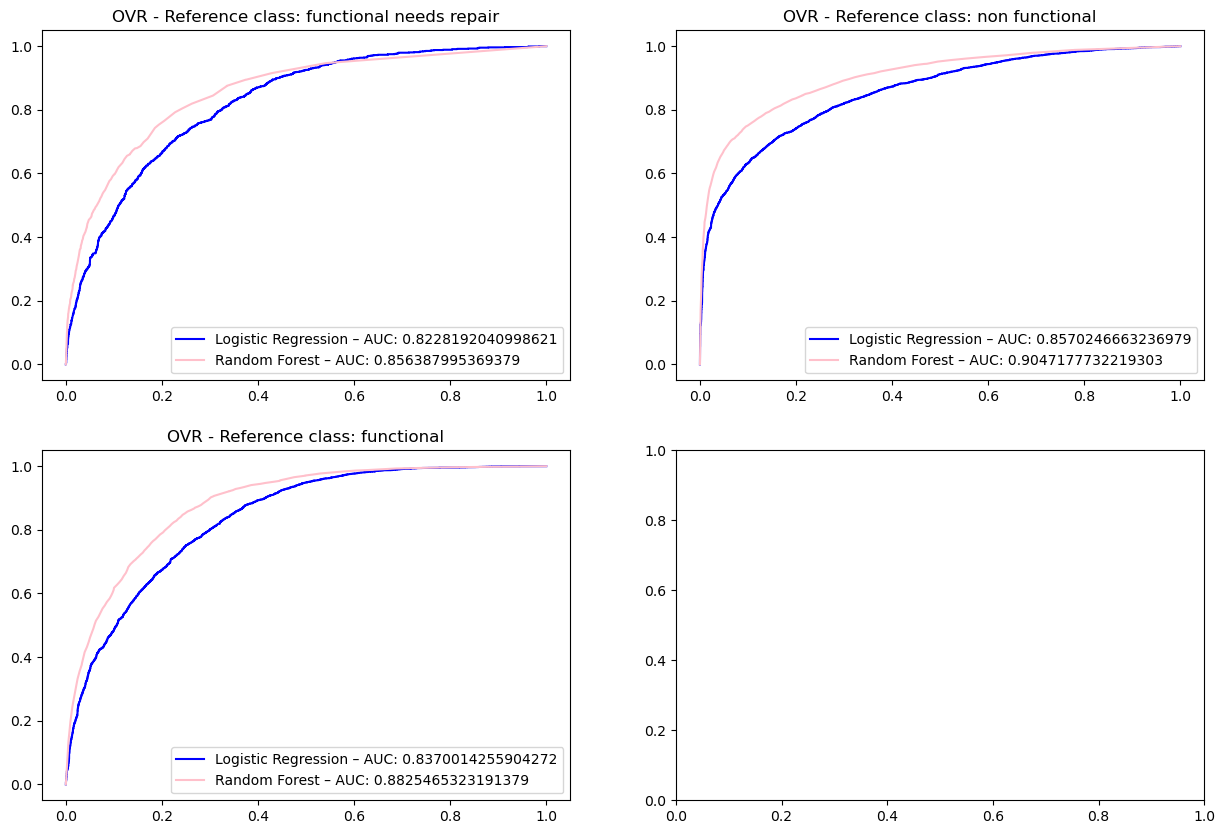

In [361]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

for i in [0,1,2]:
    
    row = i//2
    col=i%2
    
    ax[row][col].plot(xdatas[i], ydatas[i], color='blue', label=f"Logistic Regression – AUC: {auc(xdatas[i], ydatas[i])}")
    ax[row][col].plot(xdatas2[i], ydatas2[i], color='pink', label=f"Random Forest – AUC: {auc(xdatas2[i], ydatas2[i])}")
    
    ax[row][col].set_title(namez[i])
    
    ax[row][col].legend(loc=4)

### Comparing F1 Scores between models

(0.0, 1.0)

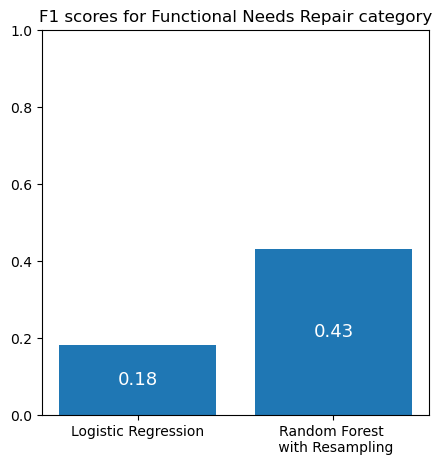

In [367]:
f1_scores = [base_report['0']['f1-score'], best_report['0']['f1-score']]

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("F1 scores for Functional Needs Repair category")
barplot = ax.bar(['Logistic Regression', 'Random Forest \n with Resampling'], f1_scores)
ax.bar_label(barplot, labels=[round(i,2) for i in f1_scores], label_type='center', color='white', fontsize='13');
ax.set_ylim(0,1)

(0.0, 1.0)

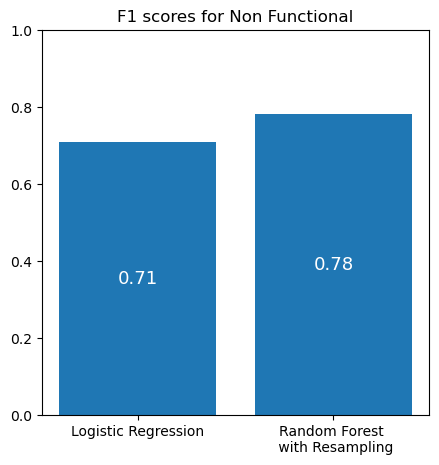

In [371]:
f1_scores = [base_report['1']['f1-score'], best_report['1']['f1-score']]

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("F1 scores for Non Functional")
barplot = ax.bar(['Logistic Regression', 'Random Forest \n with Resampling'], f1_scores)
ax.bar_label(barplot, labels=[round(i,2) for i in f1_scores], label_type='center', color='white', fontsize='13');
ax.set_ylim(0,1)

(0.0, 1.0)

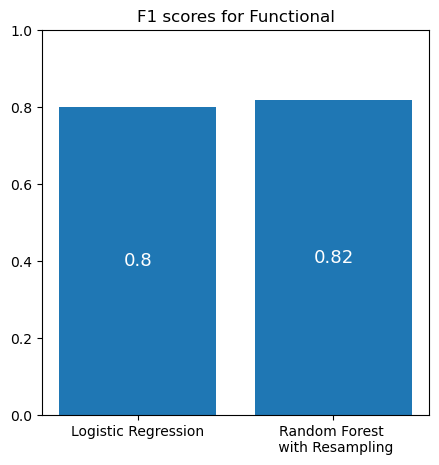

In [370]:
f1_scores = [base_report['2']['f1-score'], best_report['2']['f1-score']]

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("F1 scores for Functional")
barplot = ax.bar(['Logistic Regression', 'Random Forest \n with Resampling'], f1_scores)
ax.bar_label(barplot, labels=[round(i,2) for i in f1_scores], label_type='center', color='white', fontsize='13');
ax.set_ylim(0,1)